In [41]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
import csv
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.data import BiasedRandomWalk
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

# Load dataset

In [42]:
# Create graph for csv file with edge weights
def parse_ckn_csv(fname):
   g = nx.DiGraph()
   fields = ['from', 'to', 'type', 'reliability']
   with open(fname, newline='') as csvfile:
       reader = csv.DictReader(csvfile, fieldnames=fields, dialect=csv.excel_tab, restkey='rest', )
       for row in reader:
           g.add_edge(row['from'], row['to'], type=row['type'], reliability=row['reliability'])
           if row['type'] == 'binding':
               g.add_edge(row['to'], row['from'], type=row['type'], reliability=row['reliability'])
   return g

In [43]:
g = parse_ckn_csv("/Users/mmarzi/MLprojects/nib_ckn/data/LKN_ath_v3B_2016-08-30.txt")

In [44]:
# Check for errors in the graph
print(sorted(g.nodes)[:20])
print(sorted(g.nodes)[-20:])
isolated = list(nx.isolates(g))
print(f"isolated nodes={isolated}")
#g.remove_nodes_from(isolated)

['6K1', '6K2', 'AT1G01010', 'AT1G01020', 'AT1G01030', 'AT1G01040', 'AT1G01050', 'AT1G01060', 'AT1G01070', 'AT1G01080', 'AT1G01090', 'AT1G01100', 'AT1G01110', 'AT1G01120', 'AT1G01130', 'AT1G01140', 'AT1G01150', 'AT1G01160', 'AT1G01170', 'AT1G01180']
['MIR858', 'MIR859', 'MIR860', 'MIR861', 'MIR862', 'MIR863', 'MIR864', 'MIR865', 'MIR866', 'MIR867', 'MIR868', 'MIR869', 'MIR870', 'NIa-Pro', 'NIb', 'P1', 'P3', 'P3N-PIPO', 'R-gene', 'VPg']
isolated nodes=[]


In [45]:
list(g.edges(data=True))[:10]

[('6K1', '6K2', {'type': 'binding', 'reliability': 'r1'}),
 ('6K1', 'CI', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', '6K1', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', 'CI', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', 'NIa-Pro', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', 'VPg', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', '6K1', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', '6K2', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'AT1G30380', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'AT5G03160', {'type': 'binding', 'reliability': 'r1'})]

In [46]:
# Some general characteristics of the graph
print(f'nodes={g.number_of_nodes()}, edges={g.number_of_edges()}, density: {nx.density(g):.4f}, weak components: {nx.number_weakly_connected_components(g)}')

nodes=20011, edges=94542, density: 0.0002, weak components: 2427


Graph is sparse with a high number of weakly connected components and has a very low density (range 0-1).

In [47]:
# List of weakly connected components
[len(c) for c in sorted(nx.weakly_connected_components(g), key=len, reverse=True)][:25]

[17550, 8, 7, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]

In [48]:
from collections import Counter
from pprint import pprint
c_sizes = Counter()
for c in nx.weakly_connected_components(g):
    c_sizes[len(c)] += 1
pprint(sorted(c_sizes.items()))

[(1, 2404), (2, 19), (4, 1), (7, 1), (8, 1), (17550, 1)]


There is only one large weakly connected component that rest are negligible so we will consider only the largest component.

In [49]:
# identify the largest weakly connected component and create a corresponding subgraph
max_c = max(nx.weakly_connected_components(g))
print(f"biggest component size={len(max_c)}")
g = nx.subgraph(g, max_c)

# Some general characteristics of the subgraph
print(f"subgraph nodes={g.number_of_nodes()}, subgraph edges={g.number_of_edges()}, density: {nx.density(g):.4f}")

biggest component size=17550
subgraph nodes=17550, subgraph edges=92056, density: 0.0003


# Graph embeddings

## Node2vec embeddings

In [50]:
# # Node2vec ... try various parameter settigns
# import node2vec
# import random
# random.seed(a=12345)
# n2v = node2vec.Node2Vec(g, num_walks=300, walk_length=500, workers=4, quiet=True)

# model = n2v.fit(window=10, min_count=3, seed=42)

## Dimensionality reduction and visualisation

In [51]:
#Naredi node2vec (100dim) in naredi umap (preveri če treba prej PCA) da narišemo sliko grafa in dodaš imena vozlišč

# vzameš samo največji graf; poišči weakly connected

# Link prediction

In [52]:
G = StellarGraph.from_networkx(g)

In [53]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 17550, Edges: 92056

 Node types:
  default: [17550]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [92056]
        Weights: all 1 (default)
        Features: none


## Construct train-test splits of the graph data

### Test Graph (graph_test)

We create the test graph and test set of positive/negative edge examples from the full graph. 
* graph_test = reduced graph obtained by removing the test set of edges from the full graph. [same as source]
* examples_test = set of positive/negative edge examples (node pairs) [np_array]
* labels_test = labels of pos and neg edges (1, 0) [np_array]

In [54]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p of all positive links, and same number of negative links, from full graph, and obtain the
# reduced graph graph_test with the sampled positive links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 9205 positive and 9205 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 17550, Edges: 82851

 Node types:
  default: [17550]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [82851]
        Weights: all 1 (default)
        Features: none


In [76]:
examples_test

array([['AT5G61850', 'AT1G56020'],
       ['AT5G67540', 'AT5G22290'],
       ['AT1G16010', 'AT5G25752'],
       ...,
       ['AT4G17670', 'AT1G67080'],
       ['AT5G52670', 'AT4G24340'],
       ['AT1G77750', 'AT5G58660']], dtype=object)

In [73]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

### Train Graph

We use EdgeSplitter on Test Graph and perform  train/test split to create:
* Train Graph
* Training set of edge examples
* Model selection set of edge examples

In [55]:
# Same as above to produce a training subset from the Test Graph (graph_test)
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 8285 positive and 8285 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 17550, Edges: 74566

 Node types:
  default: [17550]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [74566]
        Weights: all 1 (default)
        Features: none


Summary of the different 

In [56]:
# Overview of splits created
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,12427,Train Graph,Test Graph,Train the Link Classifier
Model Selection,4143,Train Graph,Test Graph,Select the best Link Classifier model
Test set,18410,Test Graph,Full Graph,Evaluate the best Link Classifier


## Node embeddings

Use Node2vec to generate the node embeddings with random walks, which try to maintain the node similarity from the graph (proximity in the embedding space). Output are node pairs, which are used to train a Word2Vec model.

### Node2Vec 

In [57]:
# parameters
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [58]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")
    
    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )
    
    def get_embedding(u):
        return model.wv[u]
    
    return get_embedding

In [59]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")
# lahk tudi kar tukaj poženeš classifier

Number of random walks for 'Train Graph': 175500


## Train and evaluate the link prediction model

To use Word2Vec model for link prediction we need to perform these steps:
1. Calculate the edge embeddings for positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes
2. Train classifier to predicta binary label
3. Evaluate the perfromance of the link classifier for each binary operator on training data with node embeddings calculated on the Train Graph and select the best classifier
4. The best lassifier is used to calculate scores on the test data with node embeeddings calcluated on the Test Graph.

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1. Edge embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. Training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
                                                          
# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score, predicted = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score, predicted

def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features) ## verjetnosti za napovedi 

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column]), predicted

We use 4 different binary operators that produce link embeddings that have equal dimensionality to the input node embeddings. 

In [68]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [63]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")
      
pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,0.884690
operator_l1,0.842213
operator_l2,0.843287
operator_avg,0.787476


### Evaluate the best model using the test set

We now use the test set of embeddings and calculate a final evaluation score. 

In [64]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 175500


In [70]:
test_score, predicted = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_hadamard': 0.8319430699313513


### Create df of edges with R values and predictions

In [85]:
# Edges test examples is set of positive/negative edge examples (node pairs) that were removed from the full graph. [np_array]
examples_test

array([['AT5G61850', 'AT1G56020'],
       ['AT5G67540', 'AT5G22290'],
       ['AT1G16010', 'AT5G25752'],
       ...,
       ['AT4G17670', 'AT1G67080'],
       ['AT5G52670', 'AT4G24340'],
       ['AT1G77750', 'AT5G58660']], dtype=object)

In [95]:
# Labels of pos and neg edges (1, 0) for test edges examples [np_array]
labels_test

array([1, 1, 1, ..., 0, 0, 0])

In [87]:
# Label predicitons for each edge test example
predicted

array([[0.67724477, 0.32275523],
       [0.00832207, 0.99167793],
       [0.01601087, 0.98398913],
       ...,
       [0.66207315, 0.33792685],
       [0.35584495, 0.64415505],
       [0.50215728, 0.49784272]])

In [326]:
# Create df with the test data and predictions
df_pred = pd.DataFrame(examples_test, columns=["from", "to"])
df_pred["labels"] = labels_test
df_pred[["pred_1", "pred_0"]] = pd.DataFrame(predicted, columns=["pred_1", "pred_0"])
df_pred.drop(["pred_0"], axis=1, inplace=True)
df_pred["R-value"] = np.nan
df_pred

,from,to,labels,pred_1,R-value
0,AT5G61850,AT1G56020,1,0.677245,NaN
1,AT5G67540,AT5G22290,1,0.008322,NaN
2,AT1G16010,AT5G25752,1,0.016011,NaN
3,AT1G08890,AT5G11890,1,0.010485,NaN
4,AT1G77380,AT5G23060,1,0.020796,NaN
...,...,...,...,...,...
18405,AT3G58620,AT3G57330,0,0.631020,NaN
18406,AT5G05860,AT4G29930,0,0.443911,NaN
18407,AT4G17670,AT1G67080,0,0.662073,NaN
18408,AT5G52670,AT4G24340,0,0.355845,NaN


In [327]:
df = pd.read_csv("/Users/mmarzi/MLprojects/nib_ckn/Martin/data/LKN_ath_v3B_2016-08-30.csv", 
                 names=["from", "to", "interaction", "R-value", "pis"], sep=";", header=None)
df

,from,to,interaction,R-value,pis
0,6K1,6K2,binding,r1,NaN
1,6K1,CI,binding,r1,NaN
2,6K2,CI,binding,r1,NaN
3,6K2,NIa-Pro,binding,r1,NaN
4,6K2,VPg,binding,r1,NaN
...,...,...,...,...,...
70085,NIb,VPg,binding,r1,NaN
70086,P1,VPg,binding,r1,NaN
70087,R-gene,AT2G43790,activation,r5,PIS
70088,R-gene,AT3G45640,activation,r5,PIS


In [328]:
# # Add R value to df_pred
# df_loop = df_pred.copy()
# for idx_pred, row_pred in df_loop.iterrows():
#     for idx_org, row_org in df.iterrows():
#         if list(row_org[["from", "to"]]) == list(row_pred[["from", "to"]]):
#             df_pred.loc[idx_pred, "R-value"] = row_org["R-value"]

In [329]:
# Create dictionary edge : R-value from original df
dict_org ={}

for row in df.itertuples(name=None):
    dict_org[row[1:3]] = row[4]

# Create tuple edges in df_pred
data_edges = list(zip(df_pred["from"], df_pred["to"]))

df_pred.insert(2, "edge_tuple", value=data_edges)

In [441]:
# Map R-values from original data to pozitive edges in df_pred
df_loop = df_pred[df_pred.labels == 1].copy()

# for key in dict_org:
#     df_pred[df_pre.edge_tuple == key]["R-value"] = dict_org[key]

for idx, row in df_loop.iterrows():
    try:
        df_pred.loc[idx, "R-value"] = dict_org[row.edge_tuple]
    except KeyError:
        df_pred.loc[idx, "R-value"] = np.nan

In [442]:
df_loop

,from,to,edge_tuple,labels,pred_1,R-value
0,AT5G61850,AT1G56020,"(AT5G61850, AT1G56020)",1,0.677245,r1
1,AT5G67540,AT5G22290,"(AT5G67540, AT5G22290)",1,0.008322,NaN
2,AT1G16010,AT5G25752,"(AT1G16010, AT5G25752)",1,0.016011,r2
3,AT1G08890,AT5G11890,"(AT1G08890, AT5G11890)",1,0.010485,r2
4,AT1G77380,AT5G23060,"(AT1G77380, AT5G23060)",1,0.020796,r2
...,...,...,...,...,...,...
9200,AT5G44110,AT5G44110,"(AT5G44110, AT5G44110)",1,0.000363,r1
9201,AT3G61620,AT1G03360,"(AT3G61620, AT1G03360)",1,0.000549,NaN
9202,MIR158,AT4G17565,"(MIR158, AT4G17565)",1,0.679779,r2
9203,AT4G30850,AT3G55740,"(AT4G30850, AT3G55740)",1,0.006764,NaN


In [443]:
df_poz = df_pred[df_pred.labels == 1]
df_poz["R-value"].value_counts(dropna=False)

r2     3381
NaN    2507
r1     1790
r4     1240
r3      217
r5       70
Name: R-value, dtype: int64

In [444]:
df_poz["R-value"].value_counts(dropna=False)

r2     3381
NaN    2507
r1     1790
r4     1240
r3      217
r5       70
Name: R-value, dtype: int64

In [445]:
df_poz["R-value"].value_counts(normalize=True)

r2    0.504778
r1    0.267244
r4    0.185130
r3    0.032398
r5    0.010451
Name: R-value, dtype: float64

In [446]:
df["R-value"].value_counts(normalize=True, dropna=False)

r2    0.482665
r1    0.305878
r4    0.171950
r3    0.031003
r5    0.008503
Name: R-value, dtype: float64

In [447]:
# Drop missing values
df_poz = df_poz.dropna().copy()
df_poz

,from,to,edge_tuple,labels,pred_1,R-value
0,AT5G61850,AT1G56020,"(AT5G61850, AT1G56020)",1,0.677245,r1
2,AT1G16010,AT5G25752,"(AT1G16010, AT5G25752)",1,0.016011,r2
3,AT1G08890,AT5G11890,"(AT1G08890, AT5G11890)",1,0.010485,r2
4,AT1G77380,AT5G23060,"(AT1G77380, AT5G23060)",1,0.020796,r2
5,AT5G61850,AT2G30300,"(AT5G61850, AT2G30300)",1,0.680228,r1
...,...,...,...,...,...,...
9196,AT3G50920,AT4G19030,"(AT3G50920, AT4G19030)",1,0.024785,r2
9197,AT2G36660,AT2G36660,"(AT2G36660, AT2G36660)",1,0.678352,r1
9200,AT5G44110,AT5G44110,"(AT5G44110, AT5G44110)",1,0.000363,r1
9202,MIR158,AT4G17565,"(MIR158, AT4G17565)",1,0.679779,r2


### Graf korelacije R in predikcij 


In [448]:
# box graf; če naraščajo intervali (boxi) med Ri je kul, če ravno ni korelacije;

In [449]:
import matplotlib.pyplot as plt
import seaborn as sns

In [450]:
plot_data = df_poz.loc[:, ["R-value", "pred_1"]]
plot_data

,R-value,pred_1
0,r1,0.677245
2,r2,0.016011
3,r2,0.010485
4,r2,0.020796
5,r1,0.680228
...,...,...
9196,r2,0.024785
9197,r1,0.678352
9200,r1,0.000363
9202,r2,0.679779


<AxesSubplot:>

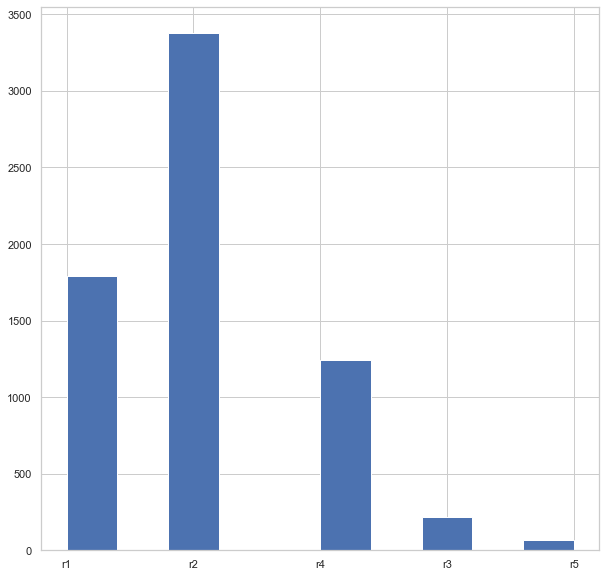

In [456]:
plot_data["R-value"].hist()

<AxesSubplot:>

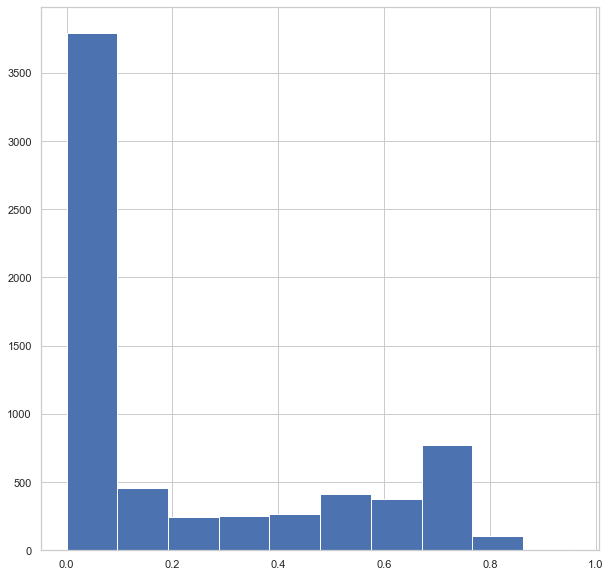

In [451]:
plot_data.pred_1.hist()

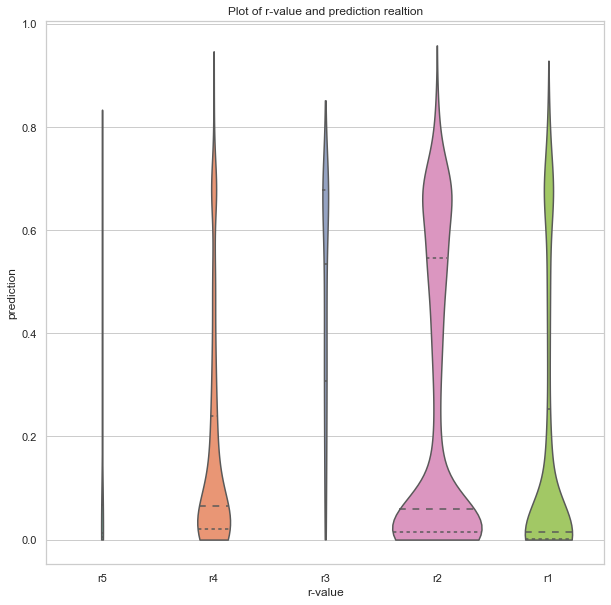

In [453]:
# plot with seaborn

sns.set(rc={'figure.figsize':(10, 10)})
sns.set_theme(style="whitegrid")
sns.violinplot(x="R-value", 
                   y="pred_1",
                   data=plot_data, 
                   order=["r5", "r4", "r3", "r2", "r1"], 
                   scale="count",
                   inner="quartile",
                   palette="Set2",
                   cut=0)

plt.xlabel("r-value")
plt.ylabel("prediction")
plt.title("Plot of r-value and prediction realtion")
plt.savefig("CKN_violinPlot_1_0.png")